In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


### Load Python Pakages

In [2]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#feature engineering
from sklearn.feature_selection import mutual_info_classif

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

#algorithms
from lightgbm import LGBMClassifier

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, RocCurveDisplay, confusion_matrix

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

random_state = 42

### Lets look into data

In [3]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col=[0])
#original_df = pd.read_csv('/kaggle/input/predict-students-dropout-and-academic-success/data.csv')
#original_df.index.names = ['id']

train_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


### Check for missing values

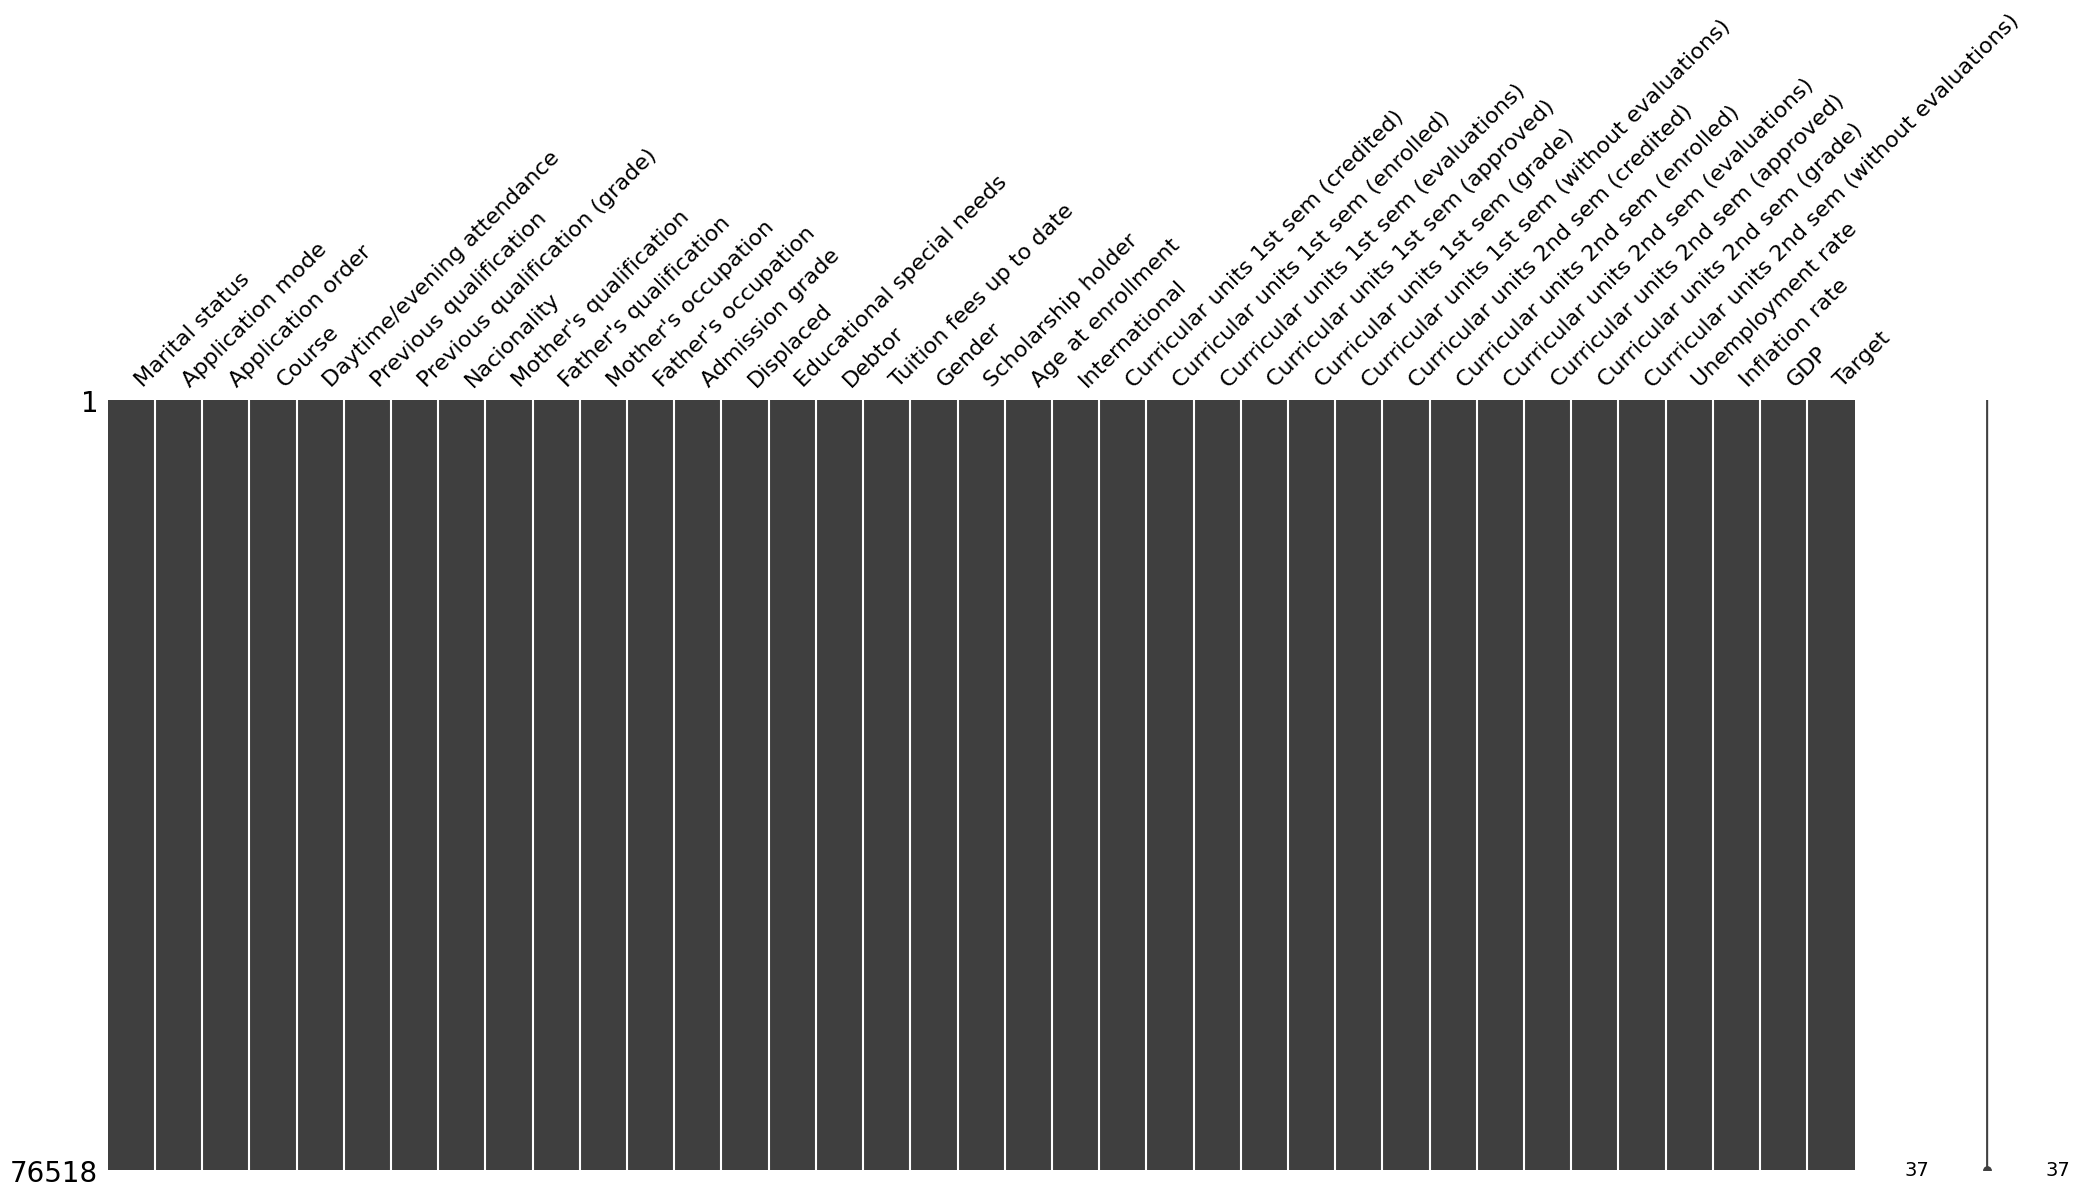

In [4]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

### Descriptive statistics

In [5]:
#numerical feature descriptive statistics

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000
Father's qualification,76518.0,23.425076,14.921164,1.00,4.000000,19.000000,37.000000,44.000


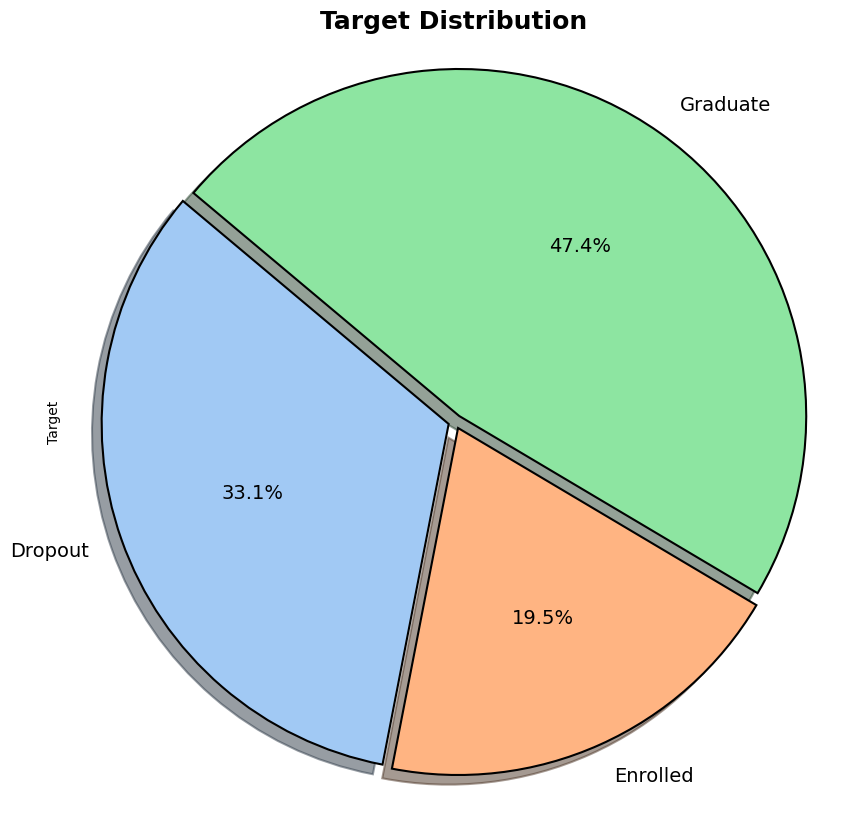

In [6]:
#Target frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.02 for _ in range(train_df['Target'].nunique())]

# Plotting
train_df.groupby('Target')['Target'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

### Grouping features for preprocessing purposes

In [7]:
train_df.nunique().sort_values()

Scholarship holder                                   2
International                                        2
Gender                                               2
Tuition fees up to date                              2
Daytime/evening attendance                           2
Debtor                                               2
Educational special needs                            2
Displaced                                            2
Target                                               3
Marital status                                       6
Application order                                    8
Unemployment rate                                   11
Curricular units 2nd sem (without evaluations)      11
GDP                                                 11
Curricular units 1st sem (without evaluations)      12
Inflation rate                                      13
Nacionality                                         18
Course                                              19
Curricular

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [9]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Target"]

target = "Target"

binary_features = ['Scholarship holder','International','Gender','Tuition fees up to date','Daytime/evening attendance','Debtor','Educational special needs','Displaced']

#from data set description
categorical_features = ['Marital status', 'Application mode', 'Course',
                'Previous qualification', 'Nacionality', "Mother's qualification", 
                "Father's qualification", "Mother's occupation",
                "Father's occupation"]


train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')
#original_df[categorical_features] = original_df[categorical_features].astype('category')

continuous_features = list(set(feature_list) - set(binary_features)- set(categorical_features))

assert feature_list.sort() == (continuous_features + binary_features + categorical_features).sort()

### Exploratory Data Analysis

In [ ]:
fig, ax = plt.subplots(5, 4, figsize=(40, 70))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Target', y=var, data=train_df, ax=subplot, palette='Set3')

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(40, 20))
for var, subplot in zip(binary_features, ax.flatten()):
    sns.barplot(x='Target', y= var, data=train_df, ax=subplot, palette='Set3')

### Feature Engineering

In [12]:
y = train_df.Target

In [13]:
# determine the mutual information for numerical features

mutual_df = train_df[feature_list ]

mutual_info = mutual_info_classif(mutual_df, y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Curricular units 2nd sem (approved),0.480612
Curricular units 2nd sem (grade),0.415702
Curricular units 1st sem (approved),0.406072
Curricular units 1st sem (grade),0.365919
Curricular units 2nd sem (evaluations),0.198004
Curricular units 1st sem (evaluations),0.190375
Course,0.118762
Tuition fees up to date,0.108057
Admission grade,0.107321
Age at enrollment,0.095786


In [ ]:
#Pair-plot for most important features
most_important_features = mutual_info[mutual_info['Numerical_Feature_MI'] > 0.15].index.tolist()
sns.pairplot(train_df[most_important_features + ["Target"]], hue="Target",  corner=True)

### Preprocessing

In [ ]:
#Just simple target encoding
label_encoder = LabelEncoder()
train_df['Target'] = label_encoder.fit_transform(train_df['Target'])
#original_df['Target'] = label_encoder.transform(original_df['Target'])

### Modeling and hyperparameter tuning

In [ ]:
train_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,2
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,0
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,0
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,1
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,2


In [ ]:
y = train_df.Target
train_df = train_df.drop("Target", axis=1)

In [ ]:
#create train-test split. 
X_dev, X_test, y_dev, y_test = train_test_split(train_df, y, 
                                                    test_size=0.1,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

def cross_validate_score(model, X_dev, y_dev, cv, X_test, label='Target', include_original=True):

    
    val_scores = []
    test_probs = np.zeros((X_test.shape[0], len(np.unique(y_dev))))
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_dev, y_dev)):
        X_train = X_dev.iloc[train_idx].reset_index(drop=True)
        y_train = y_dev.iloc[train_idx].reset_index(drop=True)
        
        X_val = X_dev.iloc[val_idx].reset_index(drop=True)
        y_val = y_dev.iloc[val_idx].reset_index(drop=True)
        
        if include_original:
            X_train = pd.concat([original_df.drop(label, axis=1), X_train]).reset_index(drop=True)
            X_train[categorical_features] = X_train[categorical_features].astype('category') # Make sure there is no weird concatination errors
            y_train = pd.concat([original_df[label], y_train]).reset_index(drop=True)
        
        model.fit(X_train, y_train)
        
        val_preds = model.predict(X_val)
        val_score = accuracy_score(y_val, val_preds)
        
        print(f'Fold {fold}: {val_score:.5f}')
        
        val_scores.append(val_score)
        
        # Predict probabilities for the test set
        test_probs += model.predict_proba(X_test) / cv.get_n_splits()
   
    mean_val_score = np.mean(val_scores)
    print(f'Mean Validation Score: {mean_val_score:.7f}')
    
    return mean_val_score, test_probs

In [ ]:
#def objective(trial):
#    n_estimators = trial.suggest_int("n_estimators", 500, 1000)
#    max_depth = trial.suggest_int("max_depth", 2, 16)
#    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
#    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 100)
#    subsample = trial.suggest_float("subsample", 0.1, 1.0)
#    max_bin = trial.suggest_int("max_bin", 200, 550, step=10)
#    feature_fraction = trial.suggest_float("feature_fraction", 0.1, 1.0)
#    include_original = trial.suggest_categorical('include_original', [True, False])

#    lgbm_clf = LGBMClassifier(
#        n_estimators=n_estimators,
#        max_depth=max_depth,
#        learning_rate=learning_rate,
#        min_data_in_leaf=min_data_in_leaf,
#        subsample=subsample,
#        max_bin=max_bin,
#        feature_fraction=feature_fraction,
#        random_state=random_state,
#        categorical_feature=categorical_features,
#        verbose=-1
#    )

    # Create a StratifiedKFold object for cross-validation
#    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Evaluate the model using cross-validation
#    mean_val_score, _ = cross_validate_score(
#        lgbm_clf, X_dev, y_dev, cv, X_test, label='Target', include_original=include_original
#    )

#    return mean_val_score

    # Set a seed for the sampler for reproducibility
#sampler = TPESampler(seed=random_state)

    # Create a study object and optimize the objective function
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [ ]:
#Hyperparemeters found by optuna
lgbm_optuna_params = {
    'n_estimators': 926,
    'max_depth': 12,
    'learning_rate': 0.024130509084853504,
    'min_data_in_leaf': 26,
    'subsample': 0.24935424985742954,
    'max_bin': 290,
    'feature_fraction': 0.30717026336187037}


lgbm_tuned = LGBMClassifier(**lgbm_optuna_params, random_state=random_state, categorical_feature=categorical_features, verbose=-1)

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
mean_val_score, test_probs = cross_validate_score(lgbm_tuned, X_dev, y_dev, cv, X_test, label='Target', include_original=False)

Fold 0: 0.83048
Fold 1: 0.83584
Fold 2: 0.83206
Fold 3: 0.83315
Fold 4: 0.83816
Mean Validation Score: 0.8339384


In [23]:
#notice how test predictions are get in cv function
#One vay of getting test predictions is fitting whole data after cv
#Another way is aggregating predictions from different models trained in each iteration of cv
#Here I go with the second option
#(this generally yileds better results on a competitive environment. But in a production environment it is not practical for most of the cases)
print("Test Score:", accuracy_score(y_test, np.argmax(test_probs, axis=1)))

Test Score: 0.8303711447987454


### Explainable ML & Feature importances

In [ ]:
#plot feature importance and summarize model performance
#Model is trained with competition data + original data
#Let's combine original and competition data before the evaluation of test performance
#Note that this is refitting to whole training data option. Results may deviate slightly than the acutual test performance
#y_combined = pd.concat([y_dev, original_df['Target']], ignore_index=True)
#combined_df = pd.concat([X_dev, original_df.drop('Target', axis=1)], ignore_index=True)


from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, DiscriminationThreshold

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

model = lgbm_tuned
model.importance_type = 'gain'

visualgrid = [
    FeatureImportances(model,  ax=axes[0][0], colormap= 'winter'),
    ConfusionMatrix(model, ax=axes[0][1], cmap= 'GnBu'),
    ClassificationReport(model, ax=axes[1][0], cmap= 'GnBu'),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    #viz.fit(combined_df, y_combined)
    viz.fit(X_dev, y_dev)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()

Shap is another tool for explainability.

In [ ]:
import shap

model = lgbm_tuned

explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
#interventional argument breaks feature dependencies and provides better estimate

#It takes time just take some sample
test_explain = X_test.sample(frac=0.05, random_state=random_state)

shap_values = explainer.shap_values(test_explain, check_additivity=False )

# Summary plot of feature importance
shap.summary_plot(shap_values, test_explain, max_display = len(X_test) )

LGBM importance score and SHAP agree on the most and least important features. One thing good to see is ethnicity, and the additional needs of students have nothing to do with their success. Good for humanity.

### Submission

Now, we can make our submission. But before that, I want to use all available data. We cross-validated and evaluated our model on an additional set, and now we know that our hyperparameters satisfy a fair generalization. Let's use all available data to get the predictions for the competition test set.

In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
mean_val_score, test_probs = cross_validate_score(lgbm_tuned, train_df, y, cv, test_df, label='Target', include_original=False)

Fold 0: 0.83606
Fold 1: 0.83481
Fold 2: 0.83240
Fold 3: 0.83062
Fold 4: 0.83585
Mean Validation Score: 0.8339475


In [27]:
sub_preds = np.argmax(test_probs, axis=1)

In [28]:
output = pd.DataFrame({'id': test_df.index,
                       'Target': sub_preds})

output["Target"] = label_encoder.inverse_transform(output["Target"])

In [29]:
output.to_csv('submission.csv', index=False)

output.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
